In [ ]:
from models import MinimalWaveNet
from dataset import TokenDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from utils import tokenize_directory
import torch
from models import MinimalWaveNet
from utils import dequantize_audio
import numpy as np
import torch
import torch.nn.functional as F
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram

In [27]:
#Data manipulation: Tokenizing WAVs
tokens = tokenize_directory("/cs/cs152/shared/gmendoza/nsynth-test/audio")
torch.save(tokens, "music_tokens.pt")


100%|██████████████████████████████████| 4096/4096 [00:09<00:00, 450.71it/s]


In [65]:
#Training WaveNet
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MinimalWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

dataset = TokenDataset("music_tokens.pt")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device).long(), y.to(device).long()
        x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1) # 16-bit PCM normalized -> [-1,1] quantized->[0,255] each token is a class 
        logits = model(x_input)
        logits = logits.permute(0, 2, 1).reshape(-1, 256)
        y = y.reshape(-1)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(loader):.4f}")

torch.save(model.state_dict(), "wavenet_minimal.pt")


Epoch 1 - Loss: 1.6220
Epoch 2 - Loss: 1.3206
Epoch 3 - Loss: 1.2626
Epoch 4 - Loss: 1.2306
Epoch 5 - Loss: 1.2111
Epoch 6 - Loss: 1.1956
Epoch 7 - Loss: 1.1825
Epoch 8 - Loss: 1.1751
Epoch 9 - Loss: 1.1661
Epoch 10 - Loss: 1.1593


In [3]:
# Generate output 
@torch.no_grad()
def generate(model, seed_token=128, length=16000, temperature=1.0):
    model.eval()
    tokens = [seed_token]
    for _ in range(length - 1):
        x = torch.tensor(tokens[-1024:], dtype=torch.long, device=device).unsqueeze(0)
        x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1)
        logits = model(x_input)
        probs = F.softmax(logits[:, :, -1] / temperature, dim=1)
        next_token = torch.multinomial(probs, num_samples=1).item()
        tokens.append(next_token)
    return np.array(tokens, dtype=np.uint8)

model = MinimalWaveNet().to(device)
model.load_state_dict(torch.load("wavenet_minimal.pt"))

tokens = generate(model)
waveform = dequantize_audio(tokens)
Audio(waveform, rate=16000)


In [29]:
#Generate plots
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("WaveNet Training Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_spectrogram(waveform, sample_rate=16000):
    f, t, Sxx = spectrogram(waveform, fs=sample_rate, nperseg=256, noverlap=128)
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-8), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title('Generated Audio Spectrogram')
    plt.colorbar(label='Power [dB]')
    plt.tight_layout()
    plt.show()


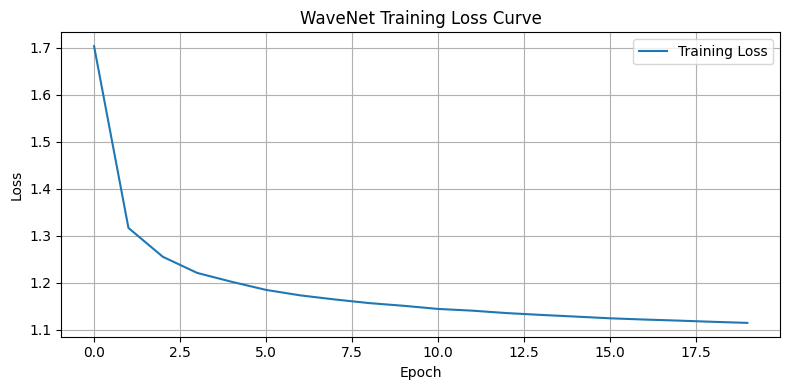

In [30]:
plot_loss_curve(train_losses)

In [ ]:
# Spectrogram looked bad, so I decided to go for a  minimal verion of the network to debug

In [ ]:
from models import MinimalWaveNet
from dataset import TokenDataset
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from utils import dequantize_audio
from IPython.display import Audio

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MinimalWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

dataset = TokenDataset("music_tokens.pt")
subset = Subset(dataset, list(range(3000))) # left off at 3000 samples, started with 8 to generate an overfit model use more examples 
loader = DataLoader(subset, batch_size=64, shuffle=True)

train_losses = []
for epoch in range(100):  
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device).long(), y.to(device).long()
        x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1)
        logits = model(x_input)
        logits = logits.permute(0, 2, 1).reshape(-1, 256)
        y = y.reshape(-1)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1} - Loss: {avg:.4f}")
    
torch.save(model.state_dict(), "wavenet_scaled16.pt")

Epoch 1 - Loss: 2.0399
Epoch 2 - Loss: 1.5196
Epoch 3 - Loss: 1.4336
Epoch 4 - Loss: 1.3884
Epoch 5 - Loss: 1.3581
Epoch 6 - Loss: 1.3355
Epoch 7 - Loss: 1.3219
Epoch 8 - Loss: 1.3046
Epoch 9 - Loss: 1.2928
Epoch 10 - Loss: 1.2863
Epoch 11 - Loss: 1.2789
Epoch 12 - Loss: 1.2641
Epoch 13 - Loss: 1.2630
Epoch 14 - Loss: 1.2572
Epoch 15 - Loss: 1.2474
Epoch 16 - Loss: 1.2436
Epoch 17 - Loss: 1.2424
Epoch 18 - Loss: 1.2338
Epoch 19 - Loss: 1.2337
Epoch 20 - Loss: 1.2252
Epoch 21 - Loss: 1.2259
Epoch 22 - Loss: 1.2199
Epoch 23 - Loss: 1.2186
Epoch 24 - Loss: 1.2145
Epoch 25 - Loss: 1.2144
Epoch 26 - Loss: 1.2131
Epoch 27 - Loss: 1.2075
Epoch 28 - Loss: 1.2077
Epoch 29 - Loss: 1.2037
Epoch 30 - Loss: 1.2068
Epoch 31 - Loss: 1.2010
Epoch 32 - Loss: 1.1970
Epoch 33 - Loss: 1.1983
Epoch 34 - Loss: 1.1938
Epoch 35 - Loss: 1.1940
Epoch 36 - Loss: 1.1914
Epoch 37 - Loss: 1.1892
Epoch 38 - Loss: 1.1922
Epoch 39 - Loss: 1.1863
Epoch 40 - Loss: 1.1882
Epoch 41 - Loss: 1.1871
Epoch 42 - Loss: 1.1827
E

In [31]:
@torch.no_grad()
def generate_from_overfit(model_path="wavenet_scaled16.pt", length=16000, temperature=1.0, seed_token=128):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MinimalWaveNet().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    tokens = [seed_token]
    for _ in range(length - 1):
        x = torch.tensor(tokens[-1024:], dtype=torch.long, device=device).unsqueeze(0)
        x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1)
        logits = model(x_input)
        probs = F.softmax(logits[:, :, -1] / temperature, dim=1)
        next_token = torch.multinomial(probs, num_samples=1).item()
        tokens.append(next_token)

    tokens = np.array(tokens, dtype=np.uint8)
    waveform = dequantize_audio(tokens)
    return waveform

# result from 3000 examples, 100 its
waveform = generate_from_overfit(length=16000, temperature=0.8)
Audio(waveform, rate=16000)


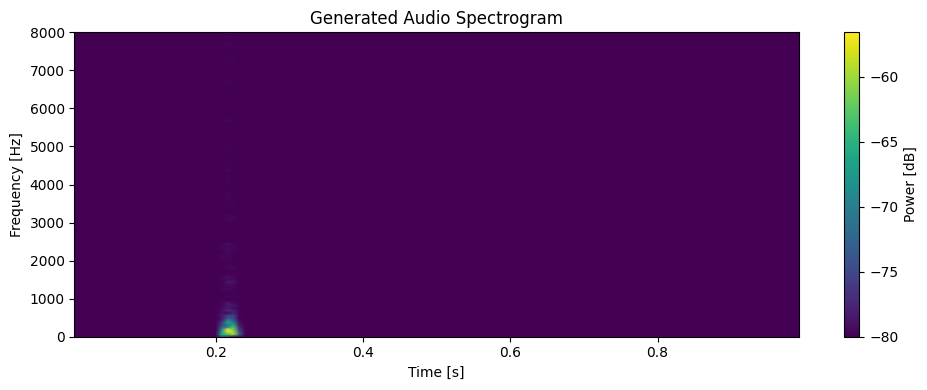

In [33]:
plot_spectrogram(waveform) #3000 examples, 100 its

In [ ]:
# perhaps temporal dependencies are not enough for the model to learn anything meaningful so we have it turning on and off randomly. 

In [ ]:
# Moving on to a conditional model to provide more structure to learn from, in this case: *instruments*

In [32]:
from utils import load_nsynth_labels, tokenize_nsynth_with_labels
from IPython.display import Audio

In [220]:
labels_dict = load_nsynth_labels(
    "/cs/cs152/shared/gmendoza/nsynth-test/examples.json",
    "/cs/cs152/shared/gmendoza/nsynth-test/audio"
)

In [221]:
tokens, labels = tokenize_nsynth_with_labels(
    "/cs/cs152/shared/gmendoza/nsynth-test/audio",
    labels_dict
)
torch.save((tokens, labels), "music_tokens_with_labels.pt")


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:07<00:00, 558.79it/s]


In [39]:
#Training loop

In [63]:
import importlib
import models
import dataset_conditional
importlib.reload(models)
importlib.reload(dataset_conditional)

<module 'dataset_conditional' from '/mnt/home/gmendoza/Project/dataset_conditional.py'>

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConditionalWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

dataset = TokenDatasetWithLabels("music_tokens_with_labels.pt")
loader = DataLoader(dataset, batch_size=4, shuffle=True) 

train_losses = []
for epoch in range(20):
    total_loss = 0
    for x, y, label in loader:
        x, y, label = x.to(device).long(), y.to(device).long(), label.to(device).long()
        x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1)
        logits = model(x_input, label)
        logits = logits.permute(0, 2, 1).reshape(-1, 256)
        y = y.reshape(-1)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1} - Loss: {avg:.4f}")

torch.save(model.state_dict(), "wavenet_conditional.pt")
# loss is looking very promising!

Epoch 1 - Loss: 1.6981
Epoch 2 - Loss: 1.3216
Epoch 3 - Loss: 1.2609
Epoch 4 - Loss: 1.2271
Epoch 5 - Loss: 1.2086
Epoch 6 - Loss: 1.1917
Epoch 7 - Loss: 1.1816
Epoch 8 - Loss: 1.1726
Epoch 9 - Loss: 1.1635
Epoch 10 - Loss: 1.1580
Epoch 11 - Loss: 1.1528
Epoch 12 - Loss: 1.1471
Epoch 13 - Loss: 1.1442
Epoch 14 - Loss: 1.1386
Epoch 15 - Loss: 1.1369
Epoch 16 - Loss: 1.1333
Epoch 17 - Loss: 1.1302
Epoch 18 - Loss: 1.1280
Epoch 19 - Loss: 1.1249
Epoch 20 - Loss: 1.1240


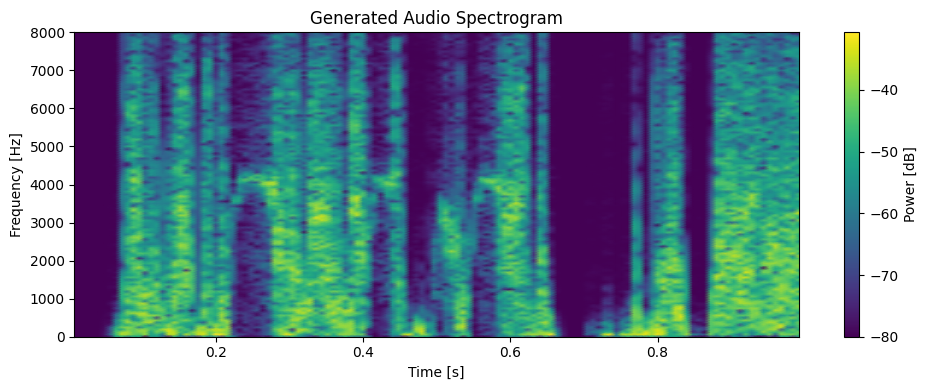

In [44]:
from utils import generate_conditional
waveform = generate_conditional("wavenet_conditional.pt", label_id=0)  # 0 = piano
Audio(waveform, rate=16000)
plot_spectrogram(waveform)

In [45]:
Audio(waveform, rate=16000)

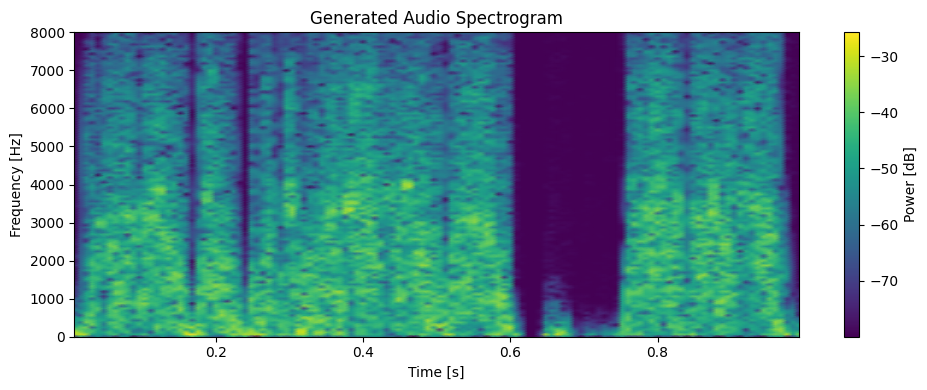

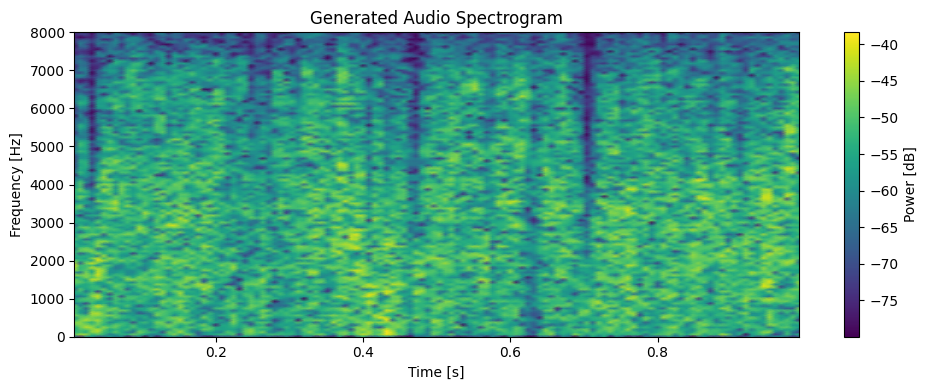

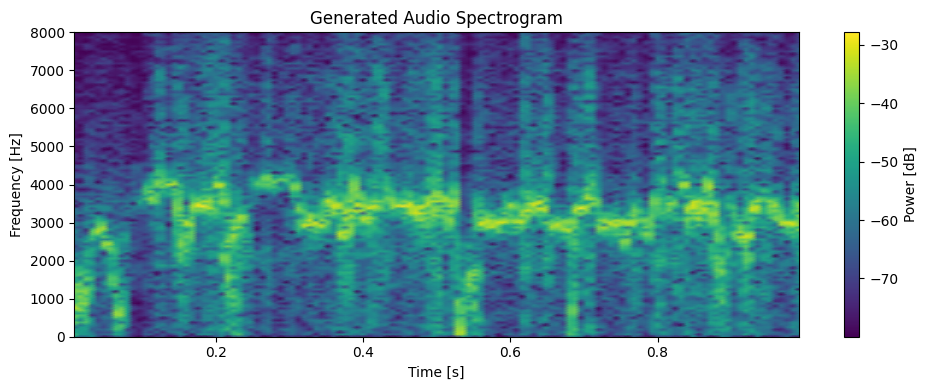

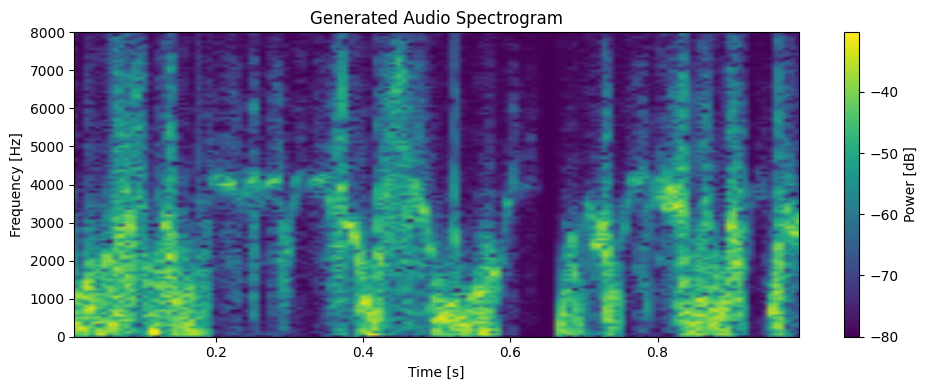

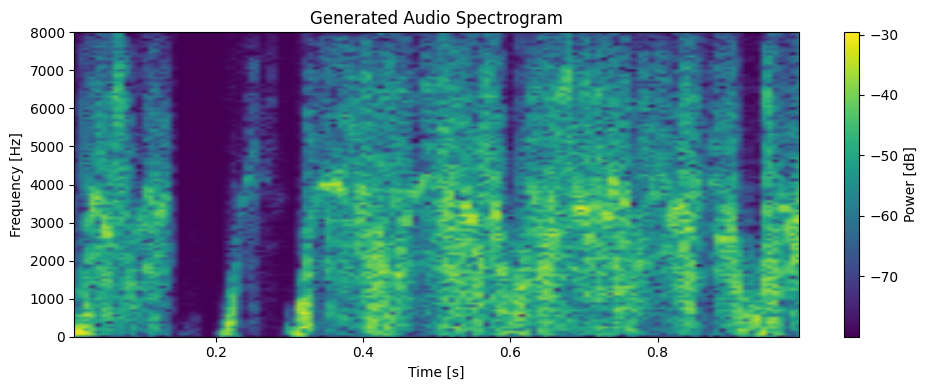

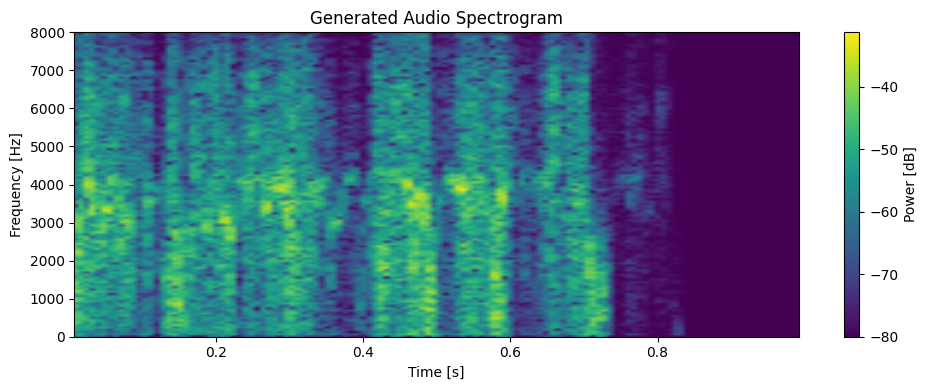

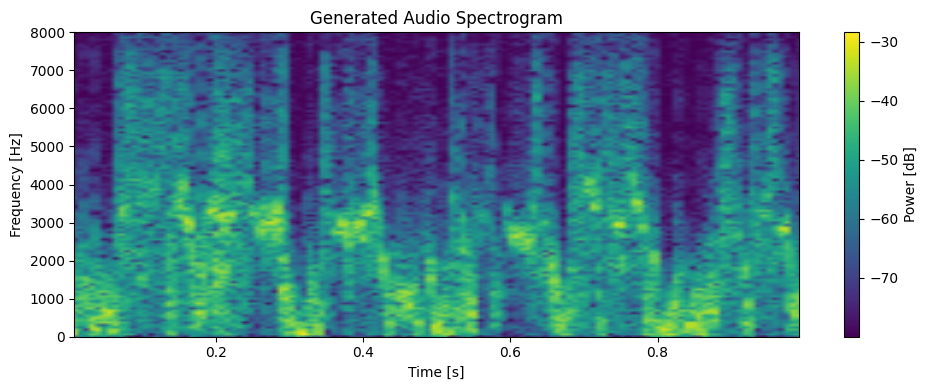

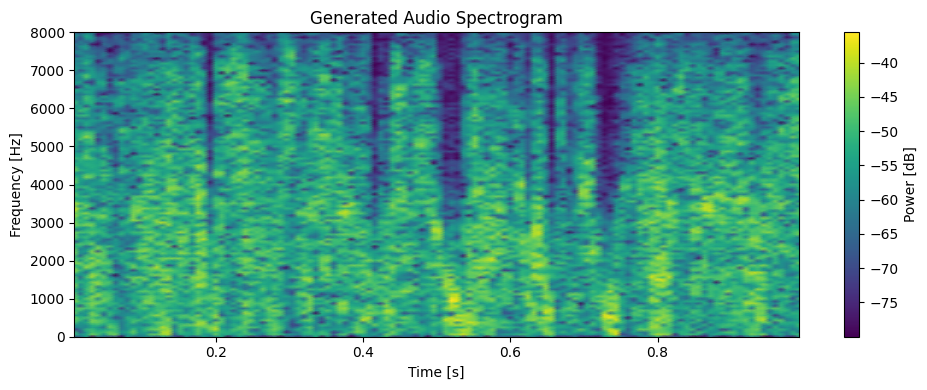

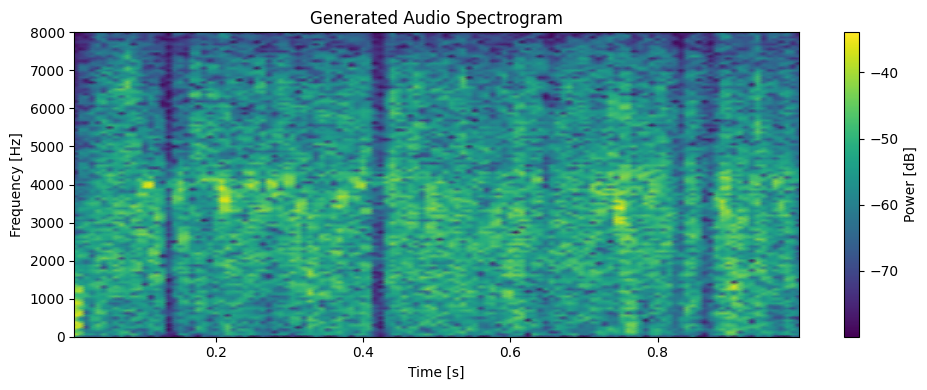

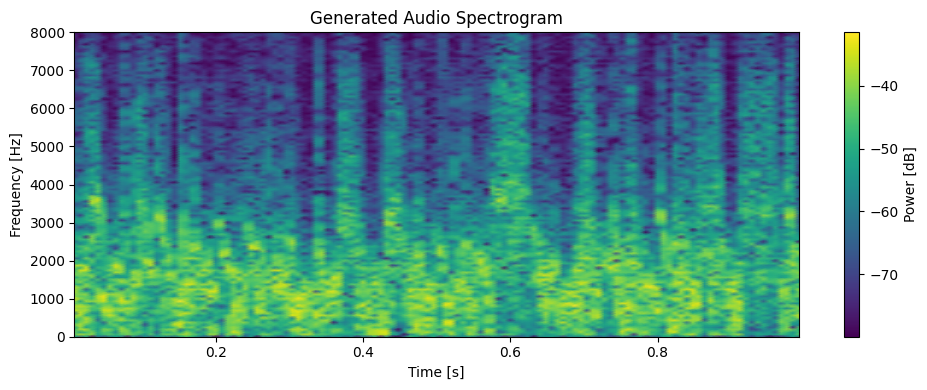

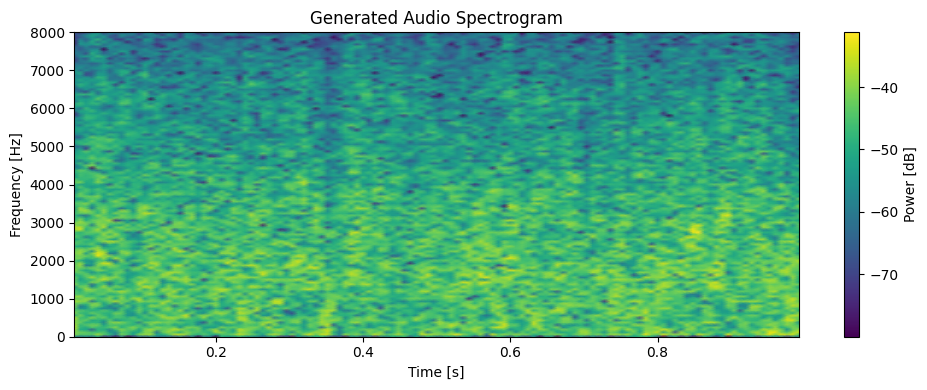

In [46]:
for i in range(11):
    waveform = generate_conditional("wavenet_conditional.pt", label_id=i)
    plot_spectrogram(waveform)
    display(Audio(waveform, rate=16000))


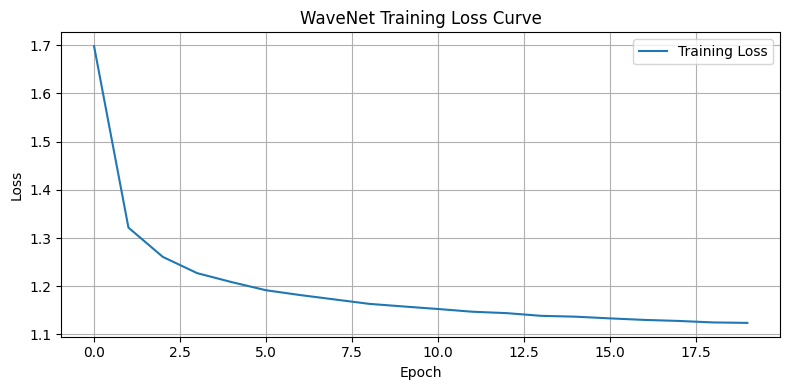

In [47]:
plot_loss_curve(train_losses)

In [ ]:
# It is clear that the model has improved a bunch from where we started; however, it is still not outputting 
# the instrument sounds that we want. Perhaps adding another type of conditioning could help?
# Adding pitch labels for conditioning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from model import ConditionalWaveNet
from dataset_conditional import NSynthConditionalDataset
from utils import generate_conditioned
from utils import tokenize_nsynth_with_labels
import librosa.display


In [57]:
tokens, labels = tokenize_nsynth_with_labels(
    "/cs/cs152/shared/gmendoza/nsynth-test/audio",
    "/cs/cs152/shared/gmendoza/nsynth-test/examples.json"
)
torch.save((tokens, labels), "music_tokens_with_pitch.pt")

100%|█████████████████████████████████| 4096/4096 [00:02<00:00, 1760.09it/s]


In [ ]:
dataset = NSynthConditionalDataset("music_tokens_with_pitch.pt")
loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True) #keeping batch number low to speed up training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConditionalWaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []

def train(num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y, inst, pitch in loader:
            x = x.to(device).long()
            y = y.to(device).long()
            inst = inst.to(device)
            pitch = pitch.to(device)

            x_input = F.one_hot(x, num_classes=256).float().permute(0, 2, 1)  # (B, 256, T)
            logits = model(x_input, inst, pitch)                              # (B, 256, T)

            logits = logits.permute(0, 2, 1).reshape(-1, 256)
            y = y.reshape(-1)

            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if (epoch + 1) % 10 == 0:
                model.eval()
                with torch.no_grad():
                    inst = torch.tensor([5], device=device)     # Example: synth_lead
                    pitch = torch.tensor([60], device=device)   # Example: Middle C
                    gen_audio = generate_conditional(model, inst, pitch, length=16000)
                    sf.write(f"generated_epoch{epoch+1}.wav", gen_audio.cpu().numpy(), samplerate=16000)
                    print(f"Generated audio at epoch {epoch+1}")
                model.train()


            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

train()

In [84]:
tokens = generate_conditioned(model, inst_class=10, pitch_class=60, length=16000)
audio = dequantize_audio(tokens)

import IPython.display as ipd
ipd.Audio(audio, rate=16000)


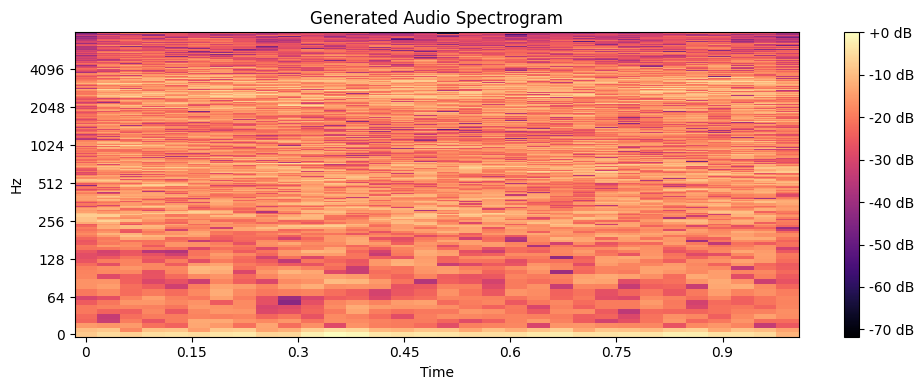

In [85]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Generated Audio Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
# Really bad results, all resolution we had has disappeared, extenended training loop is necessary 
# Here, I retried generating labels and tokens after changing the function a bit
# I also wanted to see if the issues seen were isolated to a class in specific 

In [ ]:
from models import ConditionalWaveNet
from utils import show sample

In [174]:
file_to_label = load_nsynth_labels(
    "/cs/cs152/shared/gmendoza/nsynth-test/examples.json",
    "/cs/cs152/shared/gmendoza/nsynth-test/audio"
)
tokens, labels = tokenize_nsynth_with_labels(
    "/cs/cs152/shared/gmendoza/nsynth-test/audio",
    file_to_label
)
torch.save((tokens, labels), "music_tokens_with_pitch.pt") #this file was moved to the shared folder
                                #/cs/cs152/shared/gmendoza/music_tokens_with_pitch.pt

100%|████████████████████████████| 4096/4096 [00:38<00:00, 105.08it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalWaveNet().to(device)

ckpt_path = "/cs/cs152/shared/gmendoza/checkpoints/cond_wavenet_epoch70.pt"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()


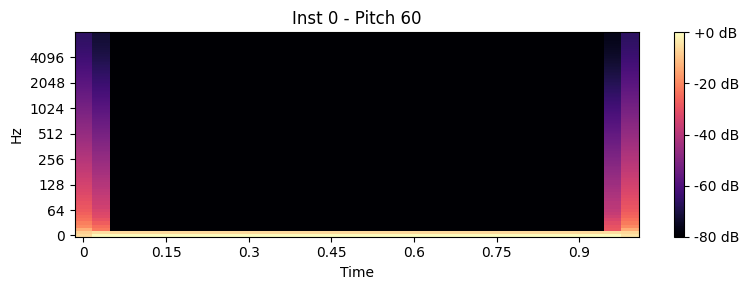

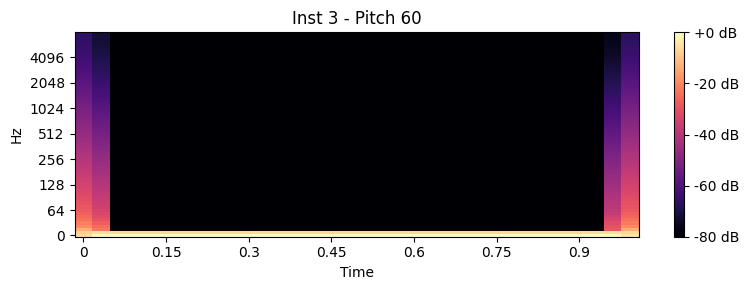

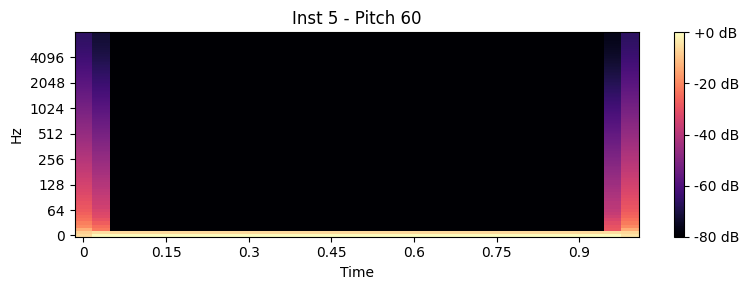

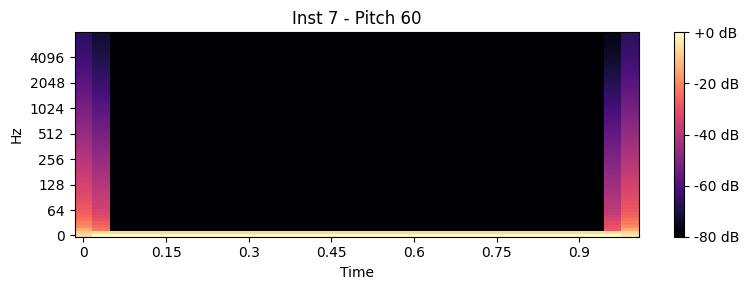

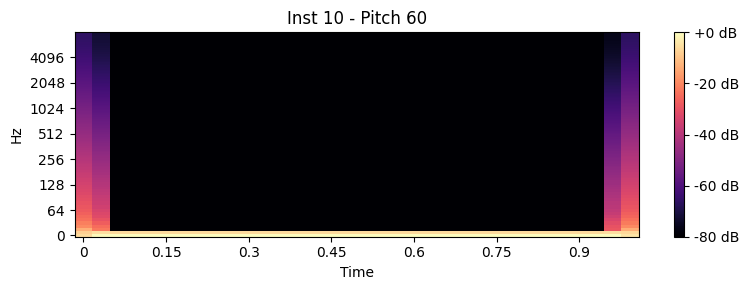

In [167]:
for inst in [0, 3, 5, 7, 10]:  # piano, bass, synth_lead, reed, fx
    show_sample(model, inst_id=inst, pitch_id=60)

In [ ]:
# The error was indeed present everywhere! Wonderful. 
# Re-training network and trying to generate sound again

In [216]:
import train_conditional
importlib.reload(train_conditional)

<module 'train_conditional' from '/mnt/home/gmendoza/Project/train_conditional.py'>

In [217]:
from train_conditional import train_with_logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = NSynthConditionalDataset("music_tokens_with_pitch.pt")
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = ConditionalWaveNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_with_logging(
    model=model,
    train_loader=loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20,
    checkpoint_dir="checkpoints",
    resume_ckpt= None 
)


Using device: cuda


Epoch 1/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.29it/s, loss=2.01]


Epoch 1 Avg Loss: 2.7041
Epoch 1 - Average Entropy: 2.12
Saved: checkpoints/cond_wavenet_epoch1.pt


Epoch 2/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:16<00:00,  1.30it/s, loss=1.55]


Epoch 2 Avg Loss: 1.7253
Epoch 2 - Average Entropy: 1.56
Saved: checkpoints/cond_wavenet_epoch2.pt


Epoch 3/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.51]


Epoch 3 Avg Loss: 1.4930
Epoch 3 - Average Entropy: 1.58
Saved: checkpoints/cond_wavenet_epoch3.pt


Epoch 4/20: 100%|███████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.2]


Epoch 4 Avg Loss: 1.4070
Epoch 4 - Average Entropy: 1.23
Saved: checkpoints/cond_wavenet_epoch4.pt


Epoch 5/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:05<00:00,  1.38it/s, loss=1.43]


Epoch 5 Avg Loss: 1.3688
Epoch 5 - Average Entropy: 1.43
Saved: checkpoints/cond_wavenet_epoch5.pt


Epoch 6/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.19]

Epoch 6 Avg Loss: 1.3297


Epoch 6 - Average Entropy: 1.23
Saved: checkpoints/cond_wavenet_epoch6.pt


Epoch 7/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.27]


Epoch 7 Avg Loss: 1.2930
Epoch 7 - Average Entropy: 1.31
Saved: checkpoints/cond_wavenet_epoch7.pt


Epoch 8/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.12]

Epoch 8 Avg Loss: 1.2803


Epoch 8 - Average Entropy: 1.15
Saved: checkpoints/cond_wavenet_epoch8.pt


Epoch 9/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:18<00:00,  1.29it/s, loss=1.17]


Epoch 9 Avg Loss: 1.2477
Epoch 9 - Average Entropy: 1.21
Saved: checkpoints/cond_wavenet_epoch9.pt


Epoch 10/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:05<00:00,  1.38it/s, loss=1.2]

Epoch 10 Avg Loss: 1.2422


Epoch 10 - Average Entropy: 1.19
Saved: checkpoints/cond_wavenet_epoch10.pt


Epoch 11/20: 100%|████████████████████████████████████████████████████████| 256/256 [03:18<00:00,  1.29it/s, loss=0.931]


Epoch 11 Avg Loss: 1.2143
Epoch 11 - Average Entropy: 0.96
Saved: checkpoints/cond_wavenet_epoch11.pt


Epoch 12/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:18<00:00,  1.29it/s, loss=1.34]


Epoch 12 Avg Loss: 1.2188
Epoch 12 - Average Entropy: 1.31
Saved: checkpoints/cond_wavenet_epoch12.pt


Epoch 13/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:18<00:00,  1.29it/s, loss=1.25]

Epoch 13 Avg Loss: 1.2067


Epoch 13 - Average Entropy: 1.24
Saved: checkpoints/cond_wavenet_epoch13.pt


Epoch 14/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.30it/s, loss=1.3]


Epoch 14 Avg Loss: 1.1921
Epoch 14 - Average Entropy: 1.32
Saved: checkpoints/cond_wavenet_epoch14.pt


Epoch 15/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:06<00:00,  1.37it/s, loss=1.15]


Epoch 15 Avg Loss: 1.1926
Epoch 15 - Average Entropy: 1.14
Saved: checkpoints/cond_wavenet_epoch15.pt


Epoch 16/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:18<00:00,  1.29it/s, loss=1.12]


Epoch 16 Avg Loss: 1.1760
Epoch 16 - Average Entropy: 1.15
Saved: checkpoints/cond_wavenet_epoch16.pt


Epoch 17/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:16<00:00,  1.30it/s, loss=1.28]


Epoch 17 Avg Loss: 1.1785
Epoch 17 - Average Entropy: 1.31
Saved: checkpoints/cond_wavenet_epoch17.pt


Epoch 18/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:17<00:00,  1.29it/s, loss=1.04]


Epoch 18 Avg Loss: 1.1536
Epoch 18 - Average Entropy: 1.02
Saved: checkpoints/cond_wavenet_epoch18.pt


Epoch 19/20: 100%|██████████████████████████████████████████████████████████| 256/256 [03:16<00:00,  1.30it/s, loss=1.2]

Epoch 19 Avg Loss: 1.1532


Epoch 19 - Average Entropy: 1.21
Saved: checkpoints/cond_wavenet_epoch19.pt


Epoch 20/20: 100%|█████████████████████████████████████████████████████████| 256/256 [03:05<00:00,  1.38it/s, loss=1.16]


Epoch 20 Avg Loss: 1.1585
Epoch 20 - Average Entropy: 1.18
Saved: checkpoints/cond_wavenet_epoch20.pt


In [226]:
import utils
importlib.reload(utils)

<module 'utils' from '/mnt/home/gmendoza/Project/utils.py'>

In [191]:
import models
importlib.reload(models)

<module 'models' from '/mnt/home/gmendoza/Project/models.py'>

In [197]:
import torch
import soundfile as sf
from models import ConditionalWaveNet
from utils import generate_conditioned

# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalWaveNet().to(device)
model.load_state_dict(torch.load("/cs/cs152/shared/gmendoza/checkpoints/cond_wavenet_epoch58.pt", map_location=device))

# --- Generate audio ---
audio = generate_conditioned(model, inst_id=0, pitch_id=60, length=16000, device=device)

# --- Save to file ---
sf.write("outputs/generated_sample.wav", audio, samplerate=16000)
print("✅ Audio saved to outputs/generated_sample.wav")


✅ Audio saved to outputs/generated_sample.wav


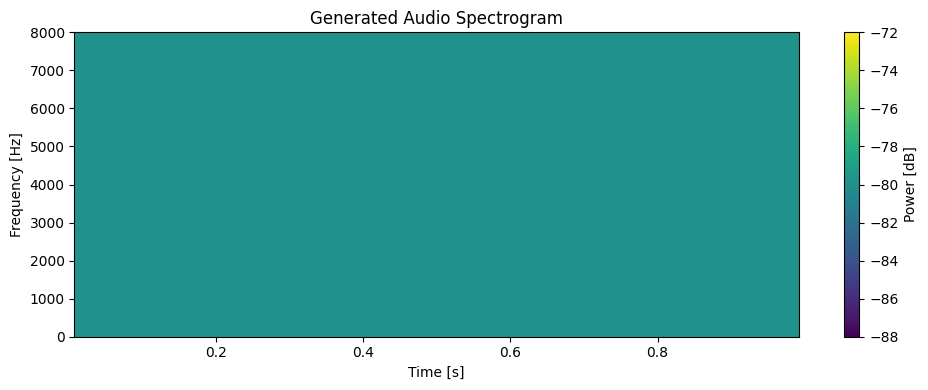

In [201]:
Audio(audio, rate=16000)
plot_spectrogram(audio)

In [202]:
print(np.unique(audio, return_counts=True))

(array([0.47450984], dtype=float32), array([16000]))


In [222]:
# It seems as though the model stops sampling from all but one token after some point.
# This happens at the same time as training is stopped and restarted/initiated from a checkpoint. 
# Re-trained the model from scratch and it seems like it is an issue with the initial token distribution

In [ ]:
# Adding mu-law tokenization (it just replaces linear quantization)

In [224]:
json_path = "/cs/cs152/shared/gmendoza/nsynth-test/examples.json"
audio_dir = "/cs/cs152/shared/gmendoza/nsynth-test/audio"

label_dict = load_nsynth_labels(json_path, audio_dir)

tokens, labels = tokenize_nsynth_with_labels(audio_dir, label_dict)
torch.save((tokens, labels), "music_tokens_mu_law.pt") #this file was removed in favor of the trimmed version 

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:29<00:00, 137.49it/s]


✅ Saved: music_tokens_mu_law.pt


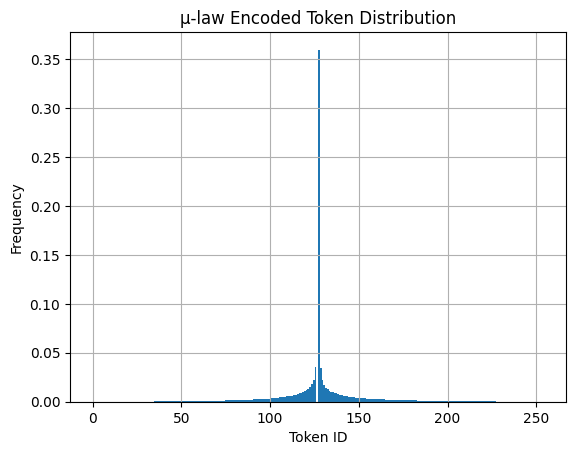

In [225]:
flat_tokens = torch.cat(tokens).numpy()
plt.hist(flat_tokens, bins=256, density=True)
plt.title("μ-law Encoded Token Distribution")
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# We see that spike due to silence before and after sounds in the data 
# Attemtping to trim samples below

In [227]:
json_path = "/cs/cs152/shared/gmendoza/nsynth-test/examples.json"
audio_dir = "/cs/cs152/shared/gmendoza/nsynth-test/audio"

label_dict = load_nsynth_labels(json_path, audio_dir)

tokens, labels = tokenize_nsynth_with_labels(audio_dir, label_dict)
torch.save((tokens, labels), "music_tokens_mu_law.pt")

100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:12<00:00, 318.14it/s]


In [ ]:
flat_tokens = torch.cat(tokens).numpy()
plt.hist(flat_tokens, bins=256, density=True)
plt.title("μ-law Encoded Token Distribution")
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()